In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from bs4 import BeautifulSoup

#stop and frisk data downloaded from 'https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page'
#data contained in 14 csv files and 1 xlsx file

root = "https://raw.githubusercontent.com/miftachowdhury/nyc_stop_and_frisk/master/data/"

#read csv files into one dataframe
sf=pd.DataFrame()

y=2003
for y in range(2003, 2017):
    i=1
    url = root+str(y)+".csv"
    try:
        df1 = pd.read_csv(url, usecols=['year', 'arstmade', 'race'], dtype='unicode')
        sf = sf.append(df1, ignore_index=True, sort=False)
    except:
        while True:
            try:
                j = "-"+str(i)
                url = root+str(y)+j+".csv"
                df1 = pd.read_csv(url, usecols=['year', 'arstmade', 'race'], dtype='unicode')
                sf = sf.append(df1, ignore_index=True, sort=False)
                i+=1
            except: break

    year arstmade race
0   2003        N    B
1   2003        N    B
2   2003        N    Q
3   2003        N    Q
4   2003        N    B
         year arstmade race
5065143  2016        N    W
5065144  2016        N    U
5065145  2016        Y    U
5065146  2016        N    W
5065147                    


In [6]:
#read xlsx file (2017 data)
df17 = pd.read_excel(root+'2017.xlsx', names=('year', 'arstmade', 'race'), usecols="D, W, BN", dtype='unicode')

#recode 2017 race values to match 2003-2016 race values
def race_recode(race):
    if race=='ASIAN/PAC.ISL': new_race='A'
    elif race=='BLACK': new_race='B'
    elif race=='AMER IND': new_race ='I'
    elif race=='BLACK HISPANIC': new_race='P'
    elif race=='WHITE HISPANIC': new_race='Q'
    elif race=='WHITE': new_race='W'
    elif race=='(null)': new_race='X'
    elif race=='MALE': new_race='X' #data entry error led to instances of 'MALE' for race
    else: new_race ='Z'
    return new_race
df17['race']=df17['race'].apply(race_recode)

#concatenate csv df (03-16) and xlsx df(17) to create one dataframe
sf=pd.concat([sf, df17], ignore_index=True)

print(sf.head(), sf.tail())

    year arstmade race
0   2003        N    B
1   2003        N    B
2   2003        N    Q
3   2003        N    Q
4   2003        N    B          year arstmade race
5076772  2017        Y    B
5076773  2017        N    Q
5076774  2017        Y    B
5076775  2017        Y    B
5076776  2017        Y    W


In [8]:
#recode black hispanic to black for purposes of this analysis
sf['race']=sf['race'].where(sf['race']!='P', 'B')

#replace empty cells with NA and check how many NAs there are in the dataframe
sf.replace(' ', np.nan, inplace=True)
    #COMMENTED CODE:print(sf.isna().sum())
    #NAs - year: 1; arstmade: 2; race: 165

#fill race NAs with X to represent "unknown" per codebook and drop remaining NAs
sf['race']=sf['race'].fillna('X')
sf.dropna(inplace=True)

#descriptives
#check number of rows in dataframe
print('There were', '{:,}'.format(len(sf)), 'stops between 2003 and 2017, inclusive.')

There were 5,076,775 stops between 2003 and 2017, inclusive.


In [12]:
df_black = sf[sf['race']=='B']

#some observations (relevant but not necessary for this analysis):
    #print(np.count_nonzero(np.where(df_black['arstmade']=='N'))) #2,762,927 stops of black people that did not lead to arrest
    #print(np.count_nonzero(df_black['arstmade'])) #2,942,275 stops of black people total
    #print(np.count_nonzero(np.where(sf['arstmade']=='N'))) #4,766,473 stops did not lead to arrest
    #print(np.count_nonzero(sf['arstmade'])) #5,076,775 stops total

#check percent of stops that did not lead to arrest, for black individuals only
print('Out of', '{:,}'.format(np.count_nonzero(df_black['arstmade'])), 'stops of black people,', '{:,}'.format(np.count_nonzero(np.where(df_black['arstmade']=='N'))), 'or around','{0:.2f}%'.format((np.count_nonzero(np.where(df_black['arstmade']=='N'))/np.count_nonzero(df_black['arstmade']))*100), 'did not result in an arrest.')

#check percent of all stops that did not lead to arrest
print('Out of', '{:,}'.format(np.count_nonzero(sf['arstmade'])), 'stops,', '{:,}'.format(np.count_nonzero(np.where(sf['arstmade']=='N'))), 'or around','{0:.2f}%'.format((np.count_nonzero(np.where(sf['arstmade']=='N'))/np.count_nonzero(sf['arstmade']))*100), 'did not result in an arrest.')

df_innocent = sf[sf['arstmade']=='N']

Out of 2,942,275 stops of black people, 2,762,927 or around 93.90% did not result in an arrest.
Out of 5,076,775 stops, 4,766,473 or around 93.89% did not result in an arrest.


In [15]:
#check percent of stops where suspect was black
all_stop_black = (np.count_nonzero(np.where(sf['race']=='B'))/np.count_nonzero(sf['race']))*100
print('Around','{0:.2f}%'.format(all_stop_black), 'of all stops were of a black person.')

#check percent of innocent stops where suspect was black
inn_stop_black = (np.count_nonzero(np.where(df_innocent['race']=='B'))/np.count_nonzero(df_innocent['race']))*100
print('Around','{0:.2f}%'.format(inn_stop_black), 'of innocent stops were of a black person.')

#from https://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/census2010/t_sf1_dp_nyc.xlsx row 86, black population in NYC is ~25.5%
print('According to the 2010 census, as reported by the NYC Dept. of City Planning, the population of NYC is ~25.5% black.')

Around 57.96% of all stops were of a black person.
Around 57.97% of innocent stops were of a black person.
According to the 2010 census, as reported by the NYC Dept. of City Planning, the population of NYC is ~25.5% black.


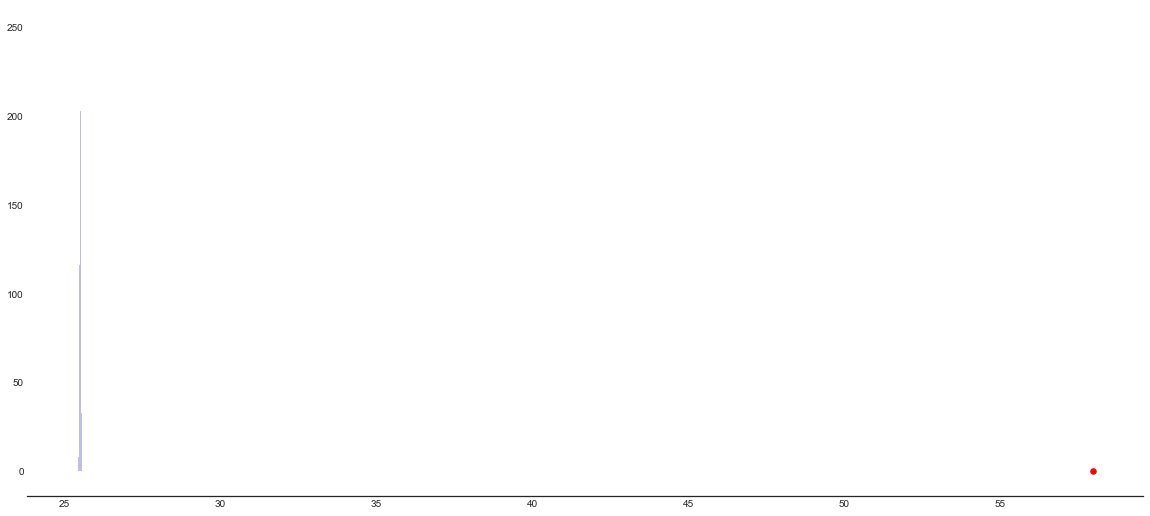

In [26]:
#QUESTION 1: Of stops that did not result in an arrest, is the person significantly more likely to be black than would be expected based on the demographics of NYC?

#The statistic: Proportion of the population of innocent stops who are black: a sample proportion of 0.5797 (57.97%)

#Method 1: Simulate a random distribution around the 25.5% black population in NYC using total number of stops as the sample size
#and then plot the 57.96% statistic on a histogram of the distribution

black_pop_nyc = [0.255, 0.745] #See above; according to the 2010 census, as reported by NYC DCP, NYC is 25.5% black

def sample_proportions(sample_size, probabilities):
    return np.random.multinomial(sample_size, probabilities) / sample_size

counts = []

for i in range(1000):
    counts.append(100*sample_proportions(len(sf), black_pop_nyc)[0])

def setUpPlot():    
    plt.style.use('seaborn-white')
    plt.figure(figsize=(20,9))
    ax = plt.subplot(1,1,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
setUpPlot()
plt.hist(counts, alpha = 0.25, color='darkblue');
plt.scatter(inn_stop_black, 0, color='red', s=30);

In [27]:
print('Based on the plot, our test statistic clearly does not fall in the distribution, suggesting that the stops are not random.')

Based on the plot, our test statistic clearly does not fall in the distribution, suggesting that the stops are not random.


In [31]:
#QUESTION 1: Of stops that did not result in an arrest, is the person significantly more likely to be black than would be expected based on the demographics of NYC?

#The statistic: Proportion of the population of innocent stops who are black: a sample proportion of 0.5797 (57.97%)

#Method 2: Run a hypothesis test, using data from the innocent stop dataframe, and 2010 Census data from NYC DCP website

from statsmodels.stats.proportion import proportions_ztest
count = np.count_nonzero(np.where(df_innocent['race']=='B'))
nobs = np.count_nonzero(df_innocent['race'])
value = 0.255
stat, pval = proportions_ztest(count, nobs, value)
print('{0:0.3f}'.format(pval))

#Confirmed that the above works because if you change 'value' to 0.58 i.e. closer to the statistic, the p-value starts to increase

0.000


In [32]:
print('Based on the p-value of 0.000 from the test, we can reject the null hypothesis, suggesting that the stops are not random.\nThis finding is true at an alpha level of 0.05 or 0.01, and alphas much lower.')

Based on the p-value of 0.000 from the test, we can reject the null hypothesis, suggesting that the stops are not random.
This finding is true at an alpha level of 0.05 or 0.01, and alphas much lower.
